In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


In [33]:
using Plots, DifferentialEquations, LinearAlgebra

In [6]:
# Defining the problem
f(u, p, t) = 1.01 * u # function defining the equation du/dt = f(u, p, t). p is a parameter 
u0 = 1 / 2 # initial condition 
tspan = (0.0, 1.0) # time interval 
prob = ODEProblem(f, u0, tspan) # constructor of the ODE problem

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

In [11]:
# Solving the problem
sol = solve(prob, reltol=1e-6, saveat=0.1)# solve with relative error 1e-6, save every 0.1
# NOTE: the points at which one saves are interpolated, so that the solver decides the stepsize on its own
# if only the endpoints are needed, one can use save_everystep = false and only the endpoint will be saved

retcode: Success
Interpolation: 1st order linear
t: 11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0
u: 11-element Vector{Float64}:
 0.5
 0.5531383208590939
 0.6119240040151778
 0.676957231440565
 0.7489019735988982
 0.8284927670912726
 0.9165421862787178
 1.0139492183860717
 1.1217083357631097
 1.240919715752011
 1.3728005084665444

In [12]:
# Choosing solvers: the library takes care of choosing the best algorithm, but we can help it
# by providing extra information e.g. the stepsize and whether we have a stiff equation
sol = solve(prob, alg_hints = [:stiff], reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: 3rd order Hermite
t: 8-element Vector{Float64}:
 0.0
 0.04348646169583638
 0.15269420264160086
 0.2960210735174629
 0.4519366592315981
 0.6294434982576307
 0.8196020482607154
 1.0
u: 8-element Vector{Float64}:
 0.5
 0.5224500727537101
 0.5833744392720251
 0.6742421926718791
 0.7892350018733854
 0.9442075758670354
 1.1441372827761083
 1.3728005075106415

In [14]:
# or simply specify the method
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Vector{Float64}:
 0.0
 0.012407826196308189
 0.042501279408579895
 0.08178049707043936
 0.12887385640801258
 0.1840979808509503
 0.24627459457746462
 0.3147930010051887
 0.38859637433902394
 0.46686179741325057
 0.5487161615794234
 0.6334347385155162
 0.7203630462759179
 0.8089580501348965
 0.8987655669818132
 0.989416255796906
 1.0
u: 17-element Vector{Float64}:
 0.5
 0.5063053789114713
 0.5219304756617815
 0.5430527172864215
 0.569506783074463
 0.6021743727412726
 0.6412025764835163
 0.6871475403116829
 0.7403258569587465
 0.8012223618319976
 0.8702768867461628
 0.9480215028766452
 1.035018702108127
 1.1319031845791006
 1.2393735398553474
 1.358203998791845
 1.3728005076225749

In [15]:
# Accessing the solution: sol is a solution object, we can get the value at the k-th step doing:
sol[8]

0.6871475403116829

In [17]:
# and the time at the k-th step doing:
sol.t[8]

0.3147930010051887

In [18]:
# one can also do funny stuff like
[t + u for (u, t) in tuples(sol)]

17-element Vector{Float64}:
 0.5
 0.5187132051077795
 0.5644317550703615
 0.6248332143568608
 0.6983806394824756
 0.7862723535922229
 0.8874771710609809
 1.0019405413168716
 1.1289222312977705
 1.268084159245248
 1.4189930483255861
 1.5814562413921616
 1.7553817483840448
 1.940861234713997
 2.1381391068371607
 2.347620254588751
 2.372800507622575

In [19]:
# Furthermore, by treating sol as a function it's possible to acess the interpolated values
sol(0.5)

0.8284927605342002

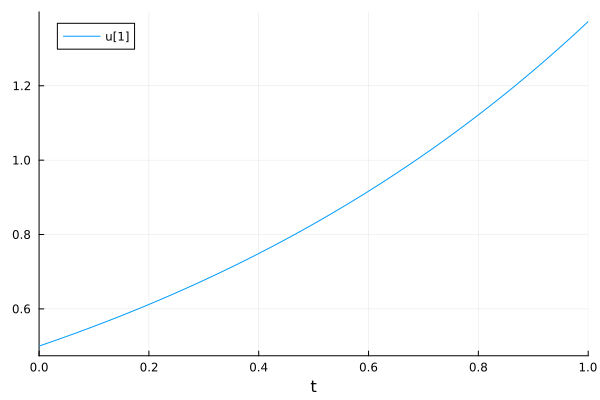

In [20]:
# Plots.jl has a recipe for plotting solutions
plot(sol)

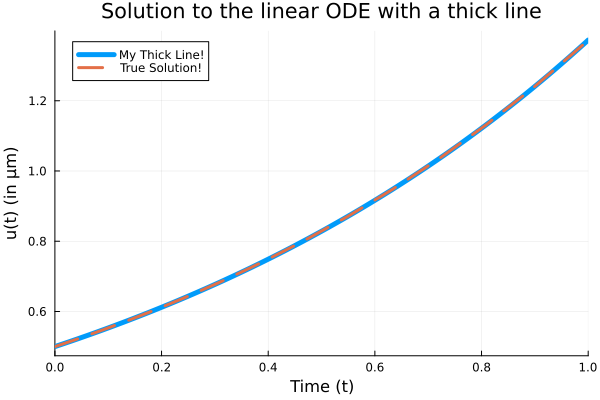

In [21]:
plot(sol, linewidth = 5, title = "Solution to the linear ODE with a thick line",
    xaxis = "Time (t)", yaxis = "u(t) (in μm)", label = "My Thick Line!") # legend=false
plot!(sol.t, t -> 0.5 * exp(1.01t), lw = 3, ls = :dash, label = "True Solution!")

# Systems of equations

In [23]:
# For performance, it's better to use updating functions
function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end
# with this, we can simply define the ODE system problem
u0 = [1.0; 0.0; 0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz!, u0, tspan)
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 1292-element Vector{Float64}:
   0.0
   3.5678604836301404e-5
   0.0003924646531993154
   0.003262408731175873
   0.009058076622686189
   0.01695647090176743
   0.027689960116420883
   0.041856352219618344
   0.060240411865493296
   0.08368541210909924
   0.11336499336103911
   0.14862181393426632
   0.1870397836913972
   ⋮
  99.25245983911758
  99.3123010170333
  99.37100059024901
  99.43545175575305
  99.50217600300971
  99.56297541572351
  99.62622492183432
  99.69561088424294
  99.77387244562912
  99.86354266863755
  99.93826978918452
 100.0
u: 1292-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [0.9996434557625105, 0.0009988049817849058, 1.781434788799189e-8]
 [0.9961045497425811, 0.010965399721242457, 2.1469553658389193e-6]
 [0.9693591548287857, 0.0897706331002921, 0.00014380191884671585]
 [0.9242043547708632, 0.24228915014052968, 0.0010461625485930237]
 [0.8800455783133068, 0.43873649717821195, 0.003424260078582332]
 [0.84

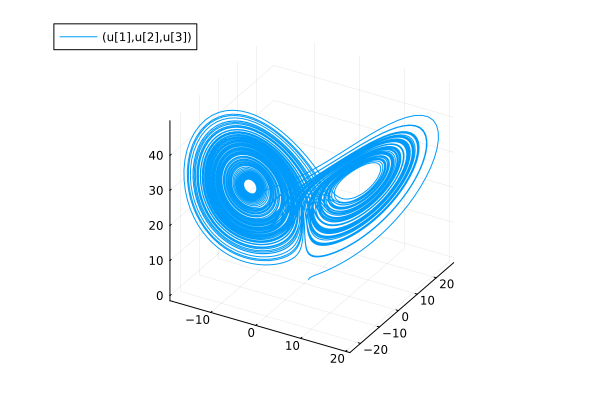

In [24]:
plot(sol, idxs = (1, 2, 3))

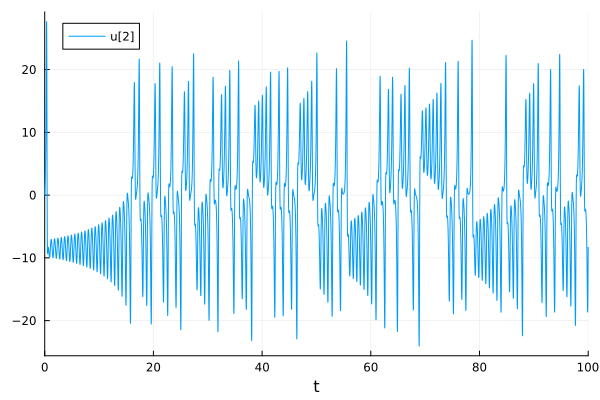

In [26]:
plot(sol, idxs = (0, 2))

# Parametrized functions

In [27]:
function parameterized_lorenz!(du, u, p, t)
    du[1] = p[1] * (u[2] - u[1])
    du[2] = u[1] * (p[2] - u[3]) - u[2]
    du[3] = u[1] * u[2] - p[3] * u[3]
end

parameterized_lorenz! (generic function with 1 method)

In [28]:
u0 = [1.0, 0.0, 0.0]
tspan = (0.0, 1.0)
p = [10.0, 28.0, 8 / 3] # this passes the values of the parameters 
prob = ODEProblem(parameterized_lorenz!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1.0)
u0: 3-element Vector{Float64}:
 1.0
 0.0
 0.0

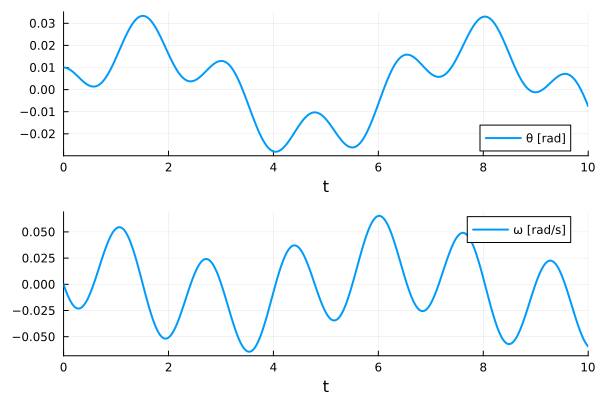

In [29]:
# using that, one can also introduce explicit time dependence
l = 1.0                             # length [m]
m = 1.0                             # mass [kg]
g = 9.81                            # gravitational acceleration [m/s²]

function pendulum!(du, u, p, t)
    du[1] = u[2]                    # θ'(t) = ω(t)
    du[2] = -3g / (2l) * sin(u[1]) + 3 / (m * l^2) * p(t) # ω'(t) = -3g/(2l) sin θ(t) + 3/(ml^2)M(t)
end

θ₀ = 0.01                           # initial angular deflection [rad]
ω₀ = 0.0                            # initial angular velocity [rad/s]
u₀ = [θ₀, ω₀]                       # initial state vector
tspan = (0.0, 10.0)                  # time interval

M = t -> 0.1sin(t)                    # external torque [Nm]

prob = ODEProblem(pendulum!, u₀, tspan, M)
sol = solve(prob)

plot(sol, linewidth = 2, xaxis = "t", label = ["θ [rad]" "ω [rad/s]"], layout = (2, 1))

In [209]:
using Random
function condition(u, t, integrator)
        real(dot(u, u)) - integrator.p[1]
end 
    
function affect!(integrator)
        # get a new 
        integrator.u = L*integrator.u / norm(L*integrator.u)
        r[1] = rand()
end
cb = ContinuousCallback(condition, affect!)
Random.seed!(seed)
prob = ODEProblem(f, u0, tspan, [rand()]) # Create an ODEProblem, that passes the callback cb to the solver
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 13-element Vector{Float64}:
  0.0
  0.12042171636511105
  0.5254945861530252
  1.106215014012966
  1.7846429549721283
  2.6056641768411053
  3.529760111771737
  4.562863479952258
  5.682148536687283
  6.880603514904785
  8.143303610882517
  9.461295294312736
 10.0
u: 13-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 1.0 + 0.0im]
 [0.0 + 0.0im, 0.9685848414145166 + 0.05838990280940587im]
 [0.0 + 0.0im, 0.8467952551567143 + 0.22775862611784436im]
 [0.0 + 0.0im, 0.6453136378384122 + 0.3984094264402971im]
 [0.0 + 0.0im, 0.40171912447759894 + 0.49832254825800437im]
 [0.0 + 0.0im, 0.13802682527418414 + 0.5027024542960479im]
 [0.0 + 0.0im, -0.07980125131615817 + 0.4060038798523415im]
 [0.0 + 0.0im, -0.2084707823480065 + 0.2422348882494788im]
 [0.0 + 0.0im, -0.23075512152583227 + 0.07151782367776954im]
 [0.0 + 0.0im, -0.1711120807084534 - 0.052681460502668476im]
 [0.0 + 0.0im, -0.07806081926813581 - 0.10466773355885677im]
 [0.0 + 0.0im, 

In [334]:
using Random
using Statistics
sigma_x = [[0, 1.0+0im] [1 ,0]]
sigma_y = [[0, -1im] [1im ,0]]
sigma_z = [[-1.0+0im, 0] [0, 1]]

# First Test: radiative damping
omega = 1
gamma = 0.5

# Correct matrix definition
He = [0.5 * omega  0.0;
      0.0         -0.5 * omega - 0.5im * gamma]
L = [0.0+0im sqrt(gamma);
    0.0 0.0]
u0 = [0.0 + 0im, 1.0 + 0im]

f(u, p, t) = -1im * He * u
tspan = (0.0, 10.0)
function prob_func(prob, i, repeat)
    Random.seed!(i)

    f = deepcopy(prob.f.f)
    
    return remake(prob, f = f, p = [rand()])
end
t_eval = collect(LinRange(tspan[1], tspan[2], 100))
prob = ODEProblem(f, u0, tspan, [rand()], saveat=t_eval, reltol=1e-8, callback=cb)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
ntraj = 1000
sim = solve(ensemble_prob, Tsit5(), EnsembleDistributed(), trajectories = ntraj);

In [301]:
sim[10]

2-element Vector{ComplexF64}:
 0.5927359956574759 + 0.8053968459592052im
                0.0 + 0.0im

In [309]:
# Average
ntimes = length(t_eval)
z_sample = zeros(Float64, ntimes, ntraj)
for k in 1:ntraj
    for tn in 1:ntimes
        psi = sim[k](t_eval[tn])
        z_sample[tn, k] = real(dot(psi, sigma_z, psi))/dot(psi, psi)
    end
end 

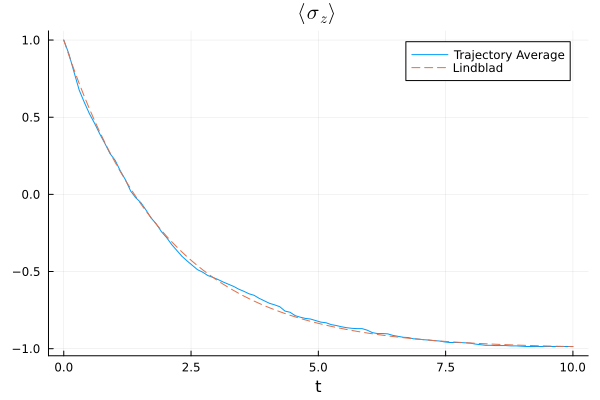

In [343]:
plot(t_eval, z_sample[:, 6], label="Sample trajectory")
plot(t_eval, dropdims(mean(z_sample, dims=2), dims=2), title=L"\langle\sigma_z\rangle", label="Trajectory Average")
plot!(t_eval, t -> 2*exp(-gamma*t) -1, label="Lindblad", xlabel="t", line=:dash)

In [321]:
sim[2]

retcode: Success
Interpolation: 1st order linear
t: 100-element Vector{Float64}:
  0.0
  0.10101010101010102
  0.20202020202020204
  0.30303030303030304
  0.4040404040404041
  0.5050505050505051
  0.6060606060606061
  0.7070707070707071
  0.8080808080808082
  0.9090909090909092
  1.0101010101010102
  1.1111111111111112
  1.2121212121212122
  ⋮
  8.88888888888889
  8.98989898989899
  9.09090909090909
  9.191919191919192
  9.292929292929292
  9.393939393939394
  9.494949494949495
  9.595959595959595
  9.696969696969697
  9.797979797979798
  9.8989898989899
 10.0
u: 100-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 1.0 + 0.0im]
 [0.0 + 0.0im, 0.9738203403107367 + 0.049224706070985426im]
 [0.0 + 0.0im, 0.9459029831824277 + 0.09587203980382591im]
 [0.0 + 0.0im, 0.916420291993287 + 0.13992393860247243im]
 [0.0 + 0.0im, 0.8855410061137597 + 0.18137129754434747im]
 [0.0 + 0.0im, 0.8534298934502683 + 0.2202135523463266im]
 [0.0 + 0.0im, 0.820247443258068 + 0.25645827454231684im]
 [0.0 + 0.